<a href="https://colab.research.google.com/github/arthur-pe/slicetca/blob/master/sliceTCA_notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Example application of sliceTCA to monkey reach data

---




In this notebook we will apply the sliceTCA pipeline to data from Churchland et al. (Nature, 2012). The data has been downloaded from the [Neural Latents Benchmark repository](https://neurallatents.github.io/datasets.html) (Pei et al., NeurIPS, 2021). For simplicity, in this notebook, we are only going to use center-out reach trials.

The data consists of microelectrode array recordings from M1 and PMd during a delayed center-out reach task. Trials were cut to a period 1000 ms pre- to 500 ms post-reach onset and spike counts were calculated using 10 ms bins.

![](https://drive.google.com/uc?export=view&id=169KKXiGL3e4byqx2ukHauAtPLPjx3OKd)


# Import packages and load data

In the following cells, we will import necessary packages and load neural and kinematic data, as well as trial-wise task information.

### Import packages

In [1]:
# install the slicetca package
!pip install slicetca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for slicetca: filename=slicetca-0.1.8-py3-none-any.whl size=19550 sha256=5bba49de0ee62080377e3de0a9e6317dfa8edce560599fa7e7c594151082074e
  Stored in directory: /root/.cache/pip/wheels/eb/78/2d/ee8cbdd01294f4e2903db119685d854f038afe9fda48cbd8e6
Successfully built slicetca


In [2]:
import slicetca

# other packages
import torch
import numpy as np
import pandas as pd
import pickle
import scipy.ndimage as spnd
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib
import gdown

# download neural data
gdown.download_folder('https://drive.google.com/drive/folders/1Uncfzp5gODu1tLc86BYmPG9lIri_8qpS', quiet=True)

['/content/example_data/Churchland2012_center-out_hand.npy',
 '/content/example_data/Churchland2012_center-out_neurons.npy',
 '/content/example_data/Churchland2012_center-out_trials.p']

### Load data

The data consists of a neural data (trials $\times$ neurons $\times$ time bins), 2-D hand trajectories (trials $\times$ coordinates $\times$ time bins), and a dataframe with trial information, such as target coordinates etc. (trials $\times$ columns).

In [3]:
# neural and kinematic data
neural_data    = np.load('example_data/Churchland2012_center-out_neurons.npy')
kinematic_data = np.load('example_data/Churchland2012_center-out_hand.npy')

# task variables
with open('example_data/Churchland2012_center-out_trials.p', 'rb') as f: trial_data = pickle.load(f).reset_index()

print('dimensions of neural data (trials, neurons, time bins):\t\t', neural_data.shape)
print('\ndimensions of kinematic data (trials, coordinates, time bins):\t', kinematic_data.shape)
print('\ndataframe columns:\n', [n for n in trial_data.columns])

dimensions of neural data (trials, neurons, time bins):		 (265, 182, 150)

dimensions of kinematic data (trials, coordinates, time bins):	 (265, 2, 150)

dataframe columns:
 ['index', 'trial', 'ttype', 'tversion', 'target_x', 'target_y', 'success', 'num_targets', 'active']


### Preprocess data

We will smoooth and scale the neural data for each neuron separately.

In [4]:
# smooth along time axis, using a Gaussian filter (sigma=2 with bin size 10 ms corresponds to 20 ms)
neural_data = spnd.gaussian_filter1d(neural_data, sigma=2, axis=-1)

# min-max scaling for each neuron for values between [0,1]
neural_data = np.array([d / d.max() for d in np.array([d - d.min() for d in neural_data])])

For condition-specific representations of neural data, we are interested in the target angle for each trial. We can calculate it from x,y coordinates found in the trial dataframe.

In [5]:
# calculate target vangle and get index for sorting trials by target angle
trial_data['angle'] = np.arctan2(trial_data.target_y.values, trial_data.target_x.values)

### Plot raw data

The subselected data is comprised of center-out reach trials with several different target locations (encoded in `df['target_x']` and `df['target_y']`). We will convert target locations to angles and then plot condition-averaged and single-trial activity of example neurons, sorted by reach condition.

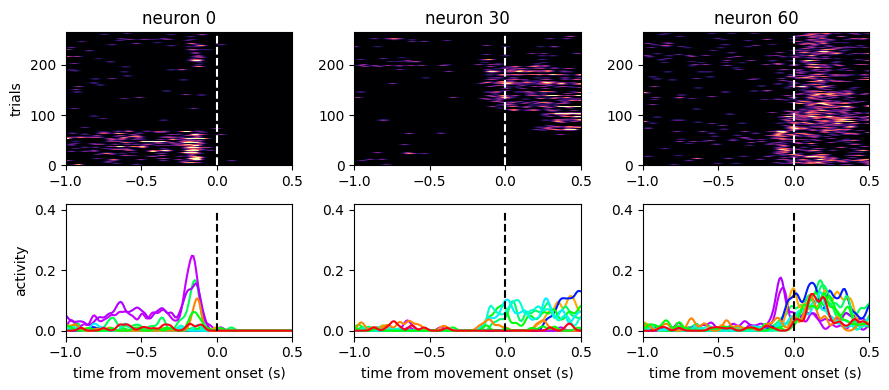

In [6]:
neurons = [0,30,60]

# index for sorting trials by reach condition
trial_idx = trial_data.sort_values(by='angle').index

# colors represent continuous target angle
colors = np.array([matplotlib.cm.get_cmap('gist_rainbow')(np.mod((i + 3*np.pi)/(np.pi * 2),1))[:3] for i in trial_data.angle.unique()])

plt.figure(figsize=(9,4), dpi=100)
# heat maps sorted by target angle for three example neurons
for ni,n in enumerate(neurons):
    plt.subplot(2,3,ni+1)
    plt.imshow(neural_data[trial_idx][:,n], aspect='auto', vmin=0, vmax=.3, extent=[-1,.5, 0, len(neural_data)], cmap='magma', origin='lower')
    plt.plot([0,0], [0,len(neural_data)], 'w--')
    if ni==0: plt.ylabel('trials')
    plt.title('neuron ' + str(n))

# condition-averaged, scaled & smoothed PSTHs
for ni,n in enumerate(neurons):
    plt.subplot(2,3,ni+4)
    for ai,a in enumerate(np.unique(trial_data['angle'])):
        plt.plot(np.linspace(-1,.5,150), np.mean(neural_data[trial_data.angle==a][:,n], axis=0), '-', color=colors[ai])
    plt.plot([0,0], [0,.4], 'k--')
    if ni==0: plt.ylabel('activity')
    plt.xlim([-1,.5])
    plt.xlabel('time from movement onset (s)')
plt.tight_layout()

We can see that single neurons show a variety of different temporal firing patterns that depend on the reach condition. From trial-averaged data, it is hard to determine smooth tuning properties in relation to target location.

# Run sliceTCA

Let's decompose the data with sliceTCA. We will use a model with 4 trial-slicing components and 1 time-slicing component.

![](https://drive.google.com/uc?export=view&id=1XvMqFLqdWDu9nnjf5Xs30fuvrtNYQVcj)

SliceTCA is based on pytorch. This enables GPU-based computing. We therefore have to select the respective processor (GPU if available, else CPU) and pass the data from numpy to torch.

In [7]:
# determine kernel to run on ('cuda' when GPU is available, else 'cpu' which will be slower)
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# transfer data to torch tensor
neural_data_tensor = torch.tensor(neural_data, device=device, dtype=torch.float32)

The sliceTCA decomposition is going to be initialized with random weights between 0 and 1 (for non-negative sliceTCA). Let's therefore rescale the data  so that initial weights have a similar magnitude as the data.

In [8]:
neural_data_tensor = neural_data_tensor/neural_data_tensor.std()

### Model fitting

Let's call the `decompose()` function from the slicetca library. It takes the data tensor and the desired number of components as necessary inputs. We will additionally specify that the decomposition should lead to non-negative weights (via `positive=True`). Moreover, we will provide a learning rate that leads to smoothly decreasing losses, a maximal number of iterations, and a stopping criterion (`min_std`) that estimates model convergence based on the standard deviation of losses over recent iterations, and a seed for reproducibility.

In [9]:
components, model = slicetca.decompose(neural_data_tensor, 
                                       number_components=(4,0,1), 
                                       positive=True, 
                                       learning_rate=5*10**-3, 
                                       min_std=10**-5, 
                                       max_iter=10000, 
                                       seed=0)

The model converged. MSE loss: 0.6093686819076538 :  56%|█████▋    | 5640/10000 [01:55<01:29, 48.96it/s]


The `decompose()` function returns estimated weights (the components) as well as the fitted model, from which a range of additional attributes can be retrieved.

To see whether the model converged, we will plot the losses saved in the model.

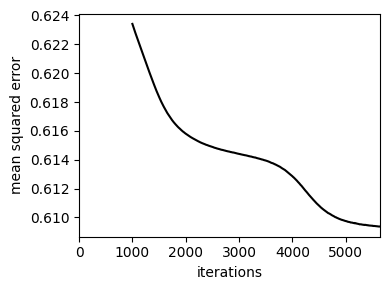

In [10]:
plt.figure(figsize=(4,3), dpi=100)
plt.plot(np.arange(1000,len(model.losses)), model.losses[1000:], 'k')
plt.xlabel('iterations')
plt.ylabel('mean squared error')
plt.xlim(0,len(model.losses))
plt.tight_layout()

Compared to unconstrained sliceTCA, invariances in non-negative sliceTCA are limited. Therefore, we only optimize the full model and skip steps 2 and 3 of the hierarchical optimization procedure. 

### Plot the components with buit-in plotting function

We will now visualize sliceTCA results by plotting the fitted components. We can use the `plot()` function from the `slicetca` package. To sort and color-code trial weights of the trial-slicing component, we will pass the `trial_idx` (which sorts trials based on target angle) and `trial_colors` arguments, as well as a vector to label the time axis.

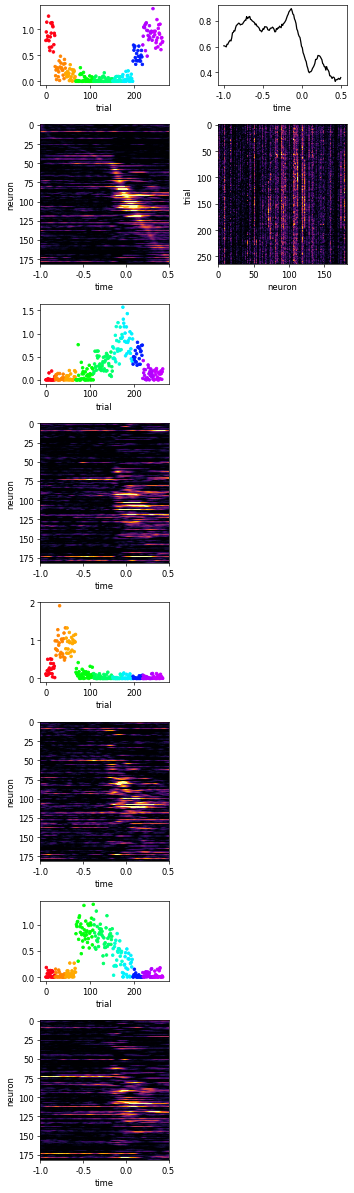

In [11]:
# define colors for each trial based on target angle
trial_colors = np.array([matplotlib.cm.get_cmap('gist_rainbow')(np.mod((i + 3*np.pi)/(np.pi * 2),1))[:3] for i in trial_data.angle.values])


# we sort the neurons of the trial slices according to their peak activity in the first slice.
neuron_sorting_peak_time = np.argsort(np.argmax(components[0][1][0], axis=1))

# call plotting function, indicating index for sorting trials and colors for different angles as well as time
axes = slicetca.plot(model, 
              variables=('trial', 'neuron', 'time'),
              colors=(trial_colors[trial_idx], None, None), # we only want the trials to be colored
              ticks=(None, None, np.linspace(0,150,4)), # we only want to modify the time ticks
              tick_labels=(None, None, np.linspace(-1,0.5,4)), 
              sorting_indices=(trial_idx, neuron_sorting_peak_time, None),
              quantile=0.99) 

First, the neural sequences captured by each component seem tuned to specific reach directions. We can now also see that trial-slicing components mostly describe neural activity after movement onset (at 0 s). In contrast, the time-slicing component mostly describes pre-motor activity.

In the next section, we will show how to reconstruct the slice-rank-5 data tensor that approximates the full dataset.

# Reconstruct the data from the fitted model

To reconstruct the approximated data tensor, you can simply call `model.construct()`. Don't forget to convert from torch to numpy: `model.construct().detach().cpu().numpy()`

In [12]:
reconstruction_full = model.construct().detach().cpu().numpy()

print(reconstruction_full.shape)

(265, 182, 150)


Sometimes, we want to reconstruct data from a single component or component type (also called partition).

In [13]:
# reconstruct from the trial-slicing partition (i.e., sum of all 4 trial-slicing component reconstructions)
reconstruction_trial_slicing = model.construct_single_partition(partition=0).detach().cpu().numpy()

# construct single time-slicing component
reconstruction_time_slicing = model.construct_single_component(partition=2, k=0).detach().cpu().numpy()

# Hand trajectory decoding from trial-slicing reconstruction

In this last section, we will map raw neural data vs. reconstructed data from the 182-dimensional space to the 2-dimensional space of hand trajectories using OLS.

Our OLS function first reshapes the neural data to a (neurons $\times$ [trials * time]) matrix, and hand trajectories to a (coordinates $\times$ [trials * time]) matrix. After mapping neural data to x,y coordinates, data is reshaped again to a tensor format. 

In [14]:
def OLS_projection(neurons, kinematics):
    
    # mapping onto x,y speed (instead of position) gives better fits
    kinematics = np.diff(kinematics, axis=-1)
    neurons = neurons[:,:,:-1]

    # reshape
    X = neurons.transpose(1,0,2).reshape(neurons.shape[1], -1).T
    X = np.concatenate([X, np.ones(len(X))[:,np.newaxis]], axis=1)
    Y = kinematics.transpose(1,0,2).reshape(kinematics.shape[1], -1).T

    # solve
    weights = np.linalg.pinv(X.T @ X) @ (X.T @ Y)

    # project and reshape
    Y_pred = (X @ weights).T

    # reshape back into original format
    Y_pred = Y_pred.reshape(kinematics.transpose(1,0,2).shape).transpose(1,0,2)

    # integrate along time axis
    Y_pred = np.cumsum(Y_pred, axis=-1)

    return Y_pred

In [15]:
# from raw data
mapping_raw = OLS_projection(neural_data[:,:,80:], kinematic_data[:,:,80:])

# from trial-slicing reconstruction
mapping_slicetca = OLS_projection(reconstruction_trial_slicing[:,:,80:], kinematic_data[:,:,80:])

### Plot decoded trajectories

Let's plot actual hand trajectories next to the mapping of raw data onto the kinematics space, and the mapping of the sliceTCA reconstruction from trial-slicing components.

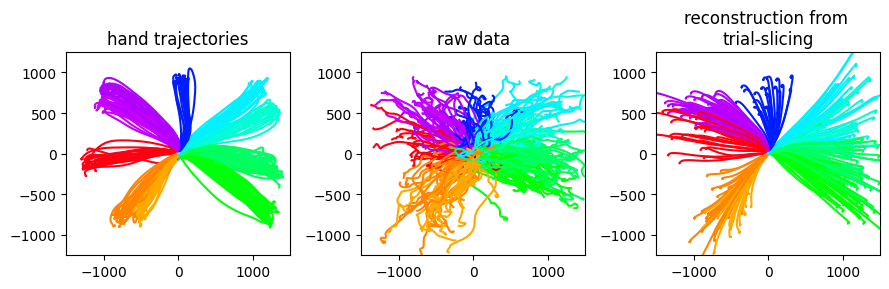

In [16]:
plot_names = ['hand trajectories', 'raw data', 'reconstruction from \ntrial-slicing']
data = [kinematic_data[:,:,80:] - kinematic_data[:,:,0][:,:,np.newaxis], mapping_raw, mapping_slicetca]
trial_colors = np.array([matplotlib.cm.get_cmap('gist_rainbow')(np.mod((i + 3*np.pi)/(np.pi * 2),1))[:3] for i in trial_data.angle.values])

plt.figure(figsize=(9,3), dpi=100)

for di,d in enumerate(data):
    plt.subplot(1,3,di+1)
    for ti,t in enumerate(d):
        plt.plot(t[0], t[1], color=trial_colors[ti])
    plt.title(plot_names[di])
    plt.xlim(-1500, 1500)
    plt.ylim(-1250, 1250)

plt.tight_layout()